<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/Module03_Hyperparameter_Tuning_sadaphule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 03 - Hyperparameter Tuning
# JHU Course EN.705742.8VL.FA23
## Student: Ravindra Sadaphule

### Notes
* This notebook runs on Google Colab ENvironement
* All data  files are read from Google Drive rom path TRAIN_FILE_FOLDER
* The notebook ran on GPU A100 with high RAM

In [ ]:
from google.colab import drive; drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import sys
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
# import warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

from warnings import simplefilter
simplefilter(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
TRAIN_FILE_FOLDER = '/content/drive/My Drive/JHU/AAML/Assignments/data/'


In [ ]:
def bc_preprocess(_df):
    # Check if we have any '?' in df values
    print(_df.columns[_df.isin(['?']).any()])
    # Check if we have any NaN in df values
    print(_df.columns[_df.isnull().any()])
    # Drop the rows with '?'
    _df = _df[~_df['node-caps'].isin(['?']) & ~_df['breast-quad'].isin(['?'])]
    # See how many rows we lost
    print(f'#rows= {len(_df)} #columns= {len(_df.columns)}')
    _df.reset_index(inplace=True, drop=True)  # required after row deletion
    return _df

# Load data
df = pd.read_csv(TRAIN_FILE_FOLDER + 'breast_cancer_preprocessed.csv')

# Sanity check
print(f'#rows= {len(df)} #columns= {len(df.columns)}')
df.head()

#rows= 286 #columns= 10


age menopause  tumor-size  inv-nodes node-caps  deg-malig breast  \
0   44   premeno          18          0       yes          3  right   
1   58      ge40          18          1        no          1  right   
2   51      ge40          39          0        no          2   left   
3   49   premeno          35          1       yes          3  right   
4   41   premeno          32          5       yes          2   left   

  breast-quad irradiat            recurrence  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events

In [ ]:
df = bc_preprocess(df)

Index(['node-caps', 'breast-quad'], dtype='object')
Index([], dtype='object')
#rows= 277 #columns= 10


In [ ]:
# feature exploration
print(df['menopause'].unique())
print(df['node-caps'].unique())
print(df['breast'].unique())
print(df['breast-quad'].unique())
print(df['irradiat'].unique())

['premeno' 'ge40' 'lt40']
['yes' 'no']
['right' 'left']
['left_up' 'central' 'left_low' 'right_up' 'right_low']
['no' 'yes']


In [ ]:
# treat binary variables as 0 and 1
df['node-caps'] = df['node-caps'].replace({'no':0, 'yes':1})
df['irradiat'] = df['irradiat'].replace({'no':0, 'yes':1})

In [ ]:
df.head()

age menopause  tumor-size  inv-nodes  node-caps  deg-malig breast  \
0   44   premeno          18          0          1          3  right   
1   58      ge40          18          1          0          1  right   
2   51      ge40          39          0          0          2   left   
3   49   premeno          35          1          1          3  right   
4   41   premeno          32          5          1          2   left   

  breast-quad  irradiat            recurrence  
0     left_up         0     recurrence-events  
1     central         0  no-recurrence-events  
2    left_low         0     recurrence-events  
3    left_low         1  no-recurrence-events  
4    right_up         0     recurrence-events

In [ ]:
def encode_onehot (_df, _f_target):
    ___df = _df.copy()
    # Convert all features of type object to one-hot encoded with pandas dummies
    for f in list(_df.columns.values):
        if _df[f].dtype == object:
            if f != _f_target:  # recurrence is the target variable and will be treated differently
                __df = pd.get_dummies(_df[f], prefix='',
                                      prefix_sep='').groupby(level=0, axis=1).max().add_prefix(f+' - ')
                _df = pd.concat([_df, __df], axis=1)
                _df = _df.drop([f], axis=1)
    return _df

# Convert the variable recurrence to numerical
df = encode_onehot(df, 'recurrence')

# Sanity check
df.head()

age  tumor-size  inv-nodes  node-caps  deg-malig  irradiat  \
0   44          18          0          1          3         0   
1   58          18          1          0          1         0   
2   51          39          0          0          2         0   
3   49          35          1          1          3         1   
4   41          32          5          1          2         0   

             recurrence  menopause - ge40  menopause - lt40  \
0     recurrence-events                 0                 0   
1  no-recurrence-events                 1                 0   
2     recurrence-events                 1                 0   
3  no-recurrence-events                 0                 0   
4     recurrence-events                 0                 0   

   menopause - premeno  breast - left  breast - right  breast-quad - central  \
0                    1              0               1                      0   
1                    0              0               1                      1   
2                    0              1               0                      0   
3                    1              0               1                      0   
4                    1              1               0                      0   

   breast-quad - left_low  breast-quad - left_up  breast-quad - right_low  \
0                       0                      1                        0   
1                       0                      0                        0   
2                       1                      0                        0   
3                       1                      0                        0   
4                       0                      0                        0   

   breast-quad - right_up  
0                       0  
1                       0  
2                       0  
3                       0  
4                       1

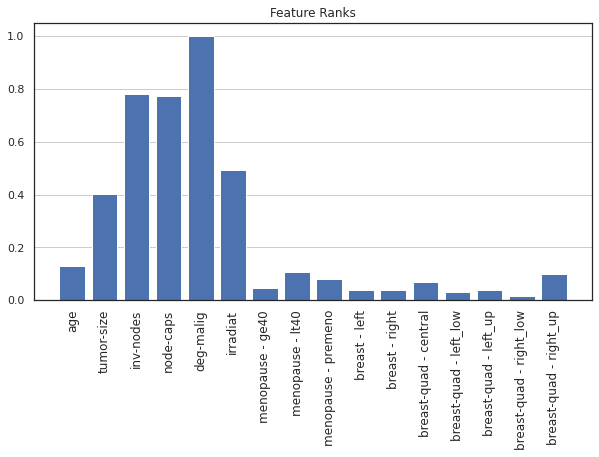

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

X = df.loc[:, df.columns != 'recurrence'].values
y = df.loc[:, df.columns == 'recurrence'].values.ravel()

selector = SelectPercentile(f_classif, percentile=10)
# Fit the data
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

# Display
plt.figure(figsize=(10,5), dpi=72)
cols = [_ for _ in df.columns if _ != 'recurrence']
y_pos = np.arange(len(cols))
plt.bar(y_pos, scores)
plt.xticks(y_pos, cols, rotation=90, fontsize=12)
plt.grid(axis='y')
plt.title('Feature Ranks')
plt.show()

In [ ]:
# Build a model
clf_lr = LogisticRegression(random_state=0, solver='sag', max_iter=10000).fit(X, y)

In [ ]:
!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_text import LimeTextExplainer

In [ ]:
'''
explainer = LimeTabularExplainer(X, mode='classification',
                                 feature_names=cols, class_names=df['recurrence'].unique().tolist(),
                                 categorical_features=None)
                                 '''

"\nexplainer = LimeTabularExplainer(X, mode='classification',\n                                 feature_names=cols, class_names=df['recurrence'].unique().tolist(),\n                                 categorical_features=None)\n                                 "

In [ ]:
explainer = LimeTabularExplainer(X, mode='classification',
                                 feature_names=cols, class_names=['no-recurrence-events','recurrence-events'],
                                 categorical_features=None)

In [ ]:
D_ID = 0
N_FEATURES= 7

exp = explainer.explain_instance(X[D_ID], clf_lr.predict_proba, num_features=N_FEATURES)

In [ ]:
exp.show_in_notebook(show_table=True)

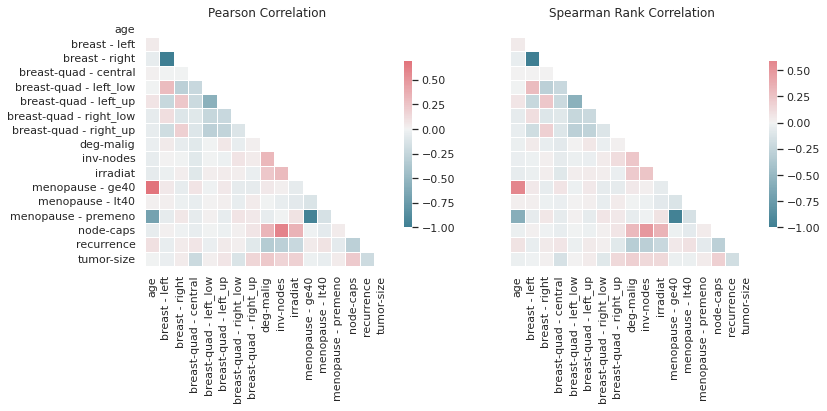

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# attempt correlation, need numericals
df_ = df.copy()
df_['recurrence'].replace({'recurrence-events':0, 'no-recurrence-events':1}, inplace=True)
df_ = df_[sorted(df_.columns)]  # explanation requires some order

# Check variable correlations to infer about strong features
corr_df1, corr_df2 = df_.corr(method='pearson'), df_.corr(method='kendall')

# Draw a lower triangle matrix since correlation is symmetrical
mask1, mask2 = np.zeros_like(corr_df1, dtype=bool), np.zeros_like(corr_df2, dtype=bool)
mask1[np.triu_indices_from(mask1)], mask2[np.triu_indices_from(mask2)] = True, True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(style="white")

_, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 12), dpi=72)
ax = ax.flatten()
sns.heatmap(corr_df1, ax=ax[0], mask=mask1, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .25})
ax[0].set_title('Pearson Correlation')
sns.heatmap(corr_df2, ax=ax[1], mask=mask2, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .25})
ax[1].set_title('Spearman Rank Correlation')
plt.show()

In [ ]:
# explore hyperparameter space
def run_classifier(_clf, _X, _y):
    tpr, fpr, acc = [], [], []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    for tr_i, ts_i in kf.split(_X, _y):
        _clf.fit(_X[tr_i], _y[tr_i])
        y_pred = _clf.predict(_X[ts_i])
        acc += [accuracy_score(_y[ts_i], y_pred)]
        tn, fp, fn, tp = confusion_matrix(_y[ts_i], y_pred, labels=[1,0]).ravel()
        tpr += [tp/(tp+fn)]  # Probability
        fpr += [fp/(fp+tn)]  # False alarm
    return np.array(acc), np.mean(tpr), np.mean(fpr)

def run_params_logisticregression(_X, _y):
    Tpr, Fpr, Acc, Std = [], [], [], []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        for solv in ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'):
            for invreg_c in (2e-1, 0.5, 0.8, 1, 2, 5, 1e1, 2e1, 1e2):
                clf = LogisticRegression(C=invreg_c, solver=solv, random_state=0, max_iter=3000)
                acc, tpr, fpr = run_classifier(clf, _X, _y)
                acc, std = np.mean(acc), np.std(acc)
                Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
                # debug
                sys.stderr.write(f"\r LR acc={acc:.2f} {chr(177)}{std:.3f}"); sys.stderr.flush()
    return Tpr, Fpr, Acc, np.array(Std)

def run_params_randomforest(_X, _y):
    Tpr, Fpr, Acc, Std = [], [], [], []
    for ne in np.linspace(20,100, num=3, dtype=int):
        for md in np.linspace(2,8, num=3, dtype=int):
            for mf in np.linspace(3,20, num=3, dtype=int):
                clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, n_jobs=-1)
                acc, tpr, fpr = run_classifier(clf, _X, _y)
                acc, std = np.mean(acc), np.std(acc)
                Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
                # debug
                sys.stderr.write(f"\r RF acc={acc:.2f} {chr(177)}{std:.3f}"); sys.stderr.flush()
    return Tpr, Fpr, Acc, np.array(Std)

def run_params_gradientboosting(_X, _y):
    Tpr, Fpr, Acc, Std = [], [], [], []
    for ne in np.linspace(10,100, num=5, dtype=int):
        clf = GradientBoostingClassifier(n_estimators=ne)
        acc, tpr, fpr = run_classifier(clf, _X, _y)
        acc, std = np.mean(acc), np.std(acc)
        Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
        # debug
        sys.stderr.write(f"\r GB acc={acc:.2f} {chr(177)}{std:.3f}"); sys.stderr.flush()
    return Tpr, Fpr, Acc, np.array(Std)


X = df_.loc[:, df_.columns != 'recurrence'].values
y = df_.loc[:, df_.columns == 'recurrence'].values.ravel()

Tpr1, Fpr1, Acc1, Std1 = run_params_logisticregression(X, y)
Tpr2, Fpr2, Acc2, Std2 = run_params_randomforest(X, y)
Tpr3, Fpr3, Acc3, Std3 = run_params_gradientboosting(X, y)


 GB acc=0.72 ±0.075

In [ ]:
# Size of the marker shows the error variance
COEF = 100
Std10 = (COEF*np.array(Std1))**2
Std20 = (COEF*np.array(Std2))**2
Std30 = (COEF*np.array(Std3))**2

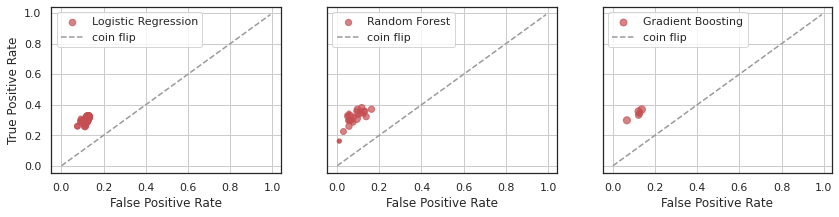

In [ ]:
def diagonal(_ax):
    _ax.plot(np.arange(0.001,1,0.01), np.arange(0.001,1,0.01), linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

_, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(14, 3), dpi=72)
ax = ax.flatten()

ax[0].scatter(Fpr1, Tpr1, s=Std10, marker='o', c='r', label='Logistic Regression', alpha=0.7)
diagonal(ax[0])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[0].legend()
ax[0].grid()

ax[1].scatter(Fpr2, Tpr2, s=Std20, marker='o', c='r', label='Random Forest', alpha=0.7)
diagonal(ax[1])
ax[1].set_xlabel('False Positive Rate')
ax[1].legend()
ax[1].grid()

ax[2].scatter(Fpr3, Tpr3, s=Std30, marker='o', c='r', label='Gradient Boosting', alpha=0.7)
diagonal(ax[2])
ax[2].set_xlabel('False Positive Rate')
ax[2].legend()
ax[2].grid()

plt.show()

# Example Text Classification

The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets of training and testing. Let's build a model and differentiate between predictions with respect to features, in this case specific words from the vocabulary.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Explore the dataset
print(fetch_20newsgroups()['target_names'])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:
# Select two classes for the lecture
Categories = ['misc.forsale', 'rec.motorcycles']

In [ ]:
# Build a model
ng_train = fetch_20newsgroups(subset='train', categories=Categories)
ng_test = fetch_20newsgroups(subset='test', categories=Categories)

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False,  # stop_words='english',
                                                             max_features=3000, dtype=np.float32)
X_train = vectorizer.fit_transform(ng_train.data)
X_test = vectorizer.transform(ng_test.data)

In [ ]:
svc = SVC(kernel='linear', probability=True).fit(X_train, ng_train.target)
print(f'Linear SVC accuracy={accuracy_score(ng_test.target, svc.predict(X_test)):.2f}')

Linear SVC accuracy=0.98


In [ ]:
rf = RandomForestClassifier(n_estimators=500).fit(X_train, ng_train.target)
print(f'RF accuracy={accuracy_score(ng_test.target, rf.predict(X_test)):.2f}')

RF accuracy=0.96


In [ ]:
c1 = make_pipeline(vectorizer, svc)
print(c1.predict_proba([ng_test.data[0]]))

explainer1 = LimeTextExplainer(class_names=Categories)

[[0.07480775 0.92519225]]


In [ ]:
c2 = make_pipeline(vectorizer, rf)
print(c2.predict_proba([ng_test.data[0]]))

explainer2 = LimeTextExplainer(class_names=Categories)

[[0.254 0.746]]


In [ ]:
DOC_ID= 42
N_FEATURES= 7

# Explain features helped this document to be classified
exp1 = explainer1.explain_instance(ng_test.data[DOC_ID], c1.predict_proba, num_features=N_FEATURES)
print(f'Document id= {DOC_ID}')
print(f'True class= {Categories[ng_test.target[DOC_ID]]}')
print()
print(f'LinearSVC Prob {Categories[1]} =, {c1.predict_proba([ng_test.data[DOC_ID]])[0,1]:.3f}')
print(', '.join([f"{w} {s:.3f}" for w,s in exp1.as_list()]))

#print(f'[w+s%.2f for w,s in exp2.as_list()]')

exp2 = explainer2.explain_instance(ng_test.data[DOC_ID], c2.predict_proba, num_features=N_FEATURES)
print()
print(f'RF Prob {Categories[1]} =, {c2.predict_proba([ng_test.data[DOC_ID]])[0,1]:.3f}')
print(', '.join([f"{w} {s:.3f}" for w,s in exp2.as_list()]))

Document id= 42
True class= rec.motorcycles

LinearSVC Prob rec.motorcycles =, 0.994
Winona 0.067, Stafford 0.065, Re 0.032, do 0.032, shaft 0.029, All -0.015, University -0.010

RF Prob rec.motorcycles =, 0.740
Re 0.145, article 0.089, In 0.078, do 0.058, what 0.056, wrote 0.037, my 0.030


In [ ]:
exp1.show_in_notebook(text=True)

In [ ]:
exp2.show_in_notebook(text=True)

In [ ]:
# Explain features helped this document to be classified, effect when removed first two features
print(f'Original SVC prediction= {svc.predict_proba(X_test[DOC_ID])[0,1]:.3f}')
tmp = X_test[DOC_ID].copy()
tmp[0,vectorizer.vocabulary_[exp1.as_list()[0][0]]] = 0
tmp[0,vectorizer.vocabulary_[exp1.as_list()[1][0]]] = 0
print(f'Prob after removing feats ({exp1.as_list()[0][0]} {exp1.as_list()[1][0]})= {svc.predict_proba(tmp)[0,1]:.3f}')
print(f'Difference= {svc.predict_proba(X_test[DOC_ID])[0,1]-svc.predict_proba(tmp)[0,1]:.3f}')
print()
print(f'Original RF prediction= {rf.predict_proba(X_test[DOC_ID])[0,1]:.3f}')
tmp = X_test[DOC_ID].copy()
tmp[0,vectorizer.vocabulary_[exp2.as_list()[0][0]]] = 0
tmp[0,vectorizer.vocabulary_[exp2.as_list()[1][0]]] = 0
print(f'Prob after removing feats ({exp2.as_list()[0][0]} {exp2.as_list()[1][0]})= {rf.predict_proba(tmp)[0,1]:.3f}')
print(f'Difference= {rf.predict_proba(X_test[DOC_ID])[0,1]-rf.predict_proba(tmp)[0,1]:.3f}')

Original SVC prediction= 0.994
Prob after removing feats (Winona Stafford)= 0.926
Difference= 0.068

Original RF prediction= 0.740
Prob after removing feats (Re article)= 0.568
Difference= 0.172


# Rule-based Explanations
Apriori analysis and association rule learning can be used to find patterns in datasets without building supervised or unspervised learning models. This kind of analysis can help interface the data scientist and the subject-matter expert about the relevancy and correctness of the data at hand, etc. Let's use mlxtend (machine learning extensions) Python library. Install with conda install mlxtend↩

Let's re-attempt breast cancer dataset. The procedure is that we will use categorical variables as they are and discretize numerical variables into {low, medium, high} like levels.



In [ ]:
# Build transactions
df = pd.read_csv(TRAIN_FILE_FOLDER + 'breast_cancer_preprocessed.csv')
df = bc_preprocess(df)

df.head()

Index(['node-caps', 'breast-quad'], dtype='object')
Index([], dtype='object')
#rows= 277 #columns= 10


age menopause  tumor-size  inv-nodes node-caps  deg-malig breast  \
0   44   premeno          18          0       yes          3  right   
1   58      ge40          18          1        no          1  right   
2   51      ge40          39          0        no          2   left   
3   49   premeno          35          1       yes          3  right   
4   41   premeno          32          5       yes          2   left   

  breast-quad irradiat            recurrence  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events

In [ ]:
!pip install mlxtend

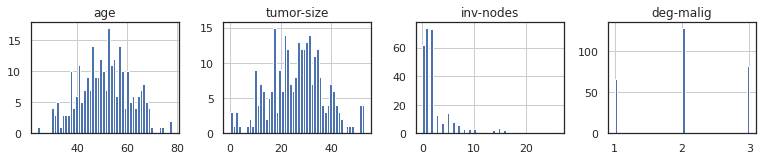

In [ ]:
# Check ranges and quantize numerical vars
df.hist(column=['age', 'tumor-size', 'inv-nodes', 'deg-malig'], bins=50, figsize=(13, 2), layout=(1,4))
plt.show()

In [ ]:
# Convert variables to nominal
df.loc[df['age']<=40, 'dage'] = 'young'
df.loc[(df['age']>40)&(df['age']<=60), 'dage'] = 'aged'
df.loc[df['age']>60, 'dage'] = 'senior'

df.loc[df['tumor-size']<=20, 'dtumorsize'] = 'ts_small'
df.loc[(df['tumor-size']>20)&(df['tumor-size']<=40), 'dtumorsize'] = 'ts_medium'
df.loc[df['tumor-size']>40, 'dtumorsize'] = 'ts_large'

df.loc[df['inv-nodes']<5, 'dnodes'] = 'nodes_low'
df.loc[df['inv-nodes']>=5, 'dnodes'] = 'nodes_high'

df.loc[df['deg-malig']<=1, 'dmalig'] = 'malig_low'
df.loc[df['deg-malig']==2, 'dmalig'] = 'malig_med'
df.loc[df['deg-malig']>=2, 'dmalig'] = 'malig_high'

df['node-caps'].replace({'no':'nc_no','yes':'nc_yes'}, inplace=True)
df['breast'].replace({'left':'br_left','right':'br_right'}, inplace=True)
df['irradiat'].replace({'no':'ir_no','yes':'ir_yes'}, inplace=True)

df.drop(columns=['age', 'tumor-size', 'inv-nodes', 'deg-malig'], inplace=True)
df.head()

menopause node-caps    breast breast-quad irradiat            recurrence  \
0   premeno    nc_yes  br_right     left_up    ir_no     recurrence-events   
1      ge40     nc_no  br_right     central    ir_no  no-recurrence-events   
2      ge40     nc_no   br_left    left_low    ir_no     recurrence-events   
3   premeno    nc_yes  br_right    left_low   ir_yes  no-recurrence-events   
4   premeno    nc_yes   br_left    right_up    ir_no     recurrence-events   

   dage dtumorsize      dnodes      dmalig  
0  aged   ts_small   nodes_low  malig_high  
1  aged   ts_small   nodes_low   malig_low  
2  aged  ts_medium   nodes_low  malig_high  
3  aged  ts_medium   nodes_low  malig_high  
4  aged  ts_medium  nodes_high  malig_high

In [ ]:
# Build transactions
Vocabulary= [_ for col in df.columns for _ in df[col].unique().tolist()]
print(Vocabulary)
Vocix = {_:i for i,_ in enumerate(Vocabulary)}

N, M = len(df), len(Vocabulary)
Transactions = np.full((N,M), False, dtype=bool)

for i,row in df.iterrows():
    for col in df.columns:
        Transactions[i][Vocix[row[col]]] = True

# Sanity, debug, print row index 10, 11
# print(f'{Transactions[10:12].astype(int)}')

['premeno', 'ge40', 'lt40', 'nc_yes', 'nc_no', 'br_right', 'br_left', 'left_up', 'central', 'left_low', 'right_up', 'right_low', 'ir_no', 'ir_yes', 'recurrence-events', 'no-recurrence-events', 'aged', 'young', 'senior', 'ts_small', 'ts_medium', 'ts_large', 'nodes_low', 'nodes_high', 'malig_high', 'malig_low']


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Create one hot DataFrame
df = pd.DataFrame(Transactions, columns=Vocabulary)

df_apriori = apriori(df, min_support=0.05, use_colnames=True, max_len=10)
print(f'{len(df_apriori)} many itemsets')
df_apriori.tail()

4301 many itemsets


support                                           itemsets
4296  0.061372  (no-recurrence-events, br_right, ir_no, nodes_...
4297  0.050542  (br_left, no-recurrence-events, nodes_low, ir_...
4298  0.050542  (br_left, no-recurrence-events, nodes_low, ir_...
4299  0.064982  (br_left, no-recurrence-events, nodes_low, ir_...
4300  0.057762  (no-recurrence-events, nodes_low, ir_no, left_...

In [ ]:
# extract rules
df_rules = association_rules(df_apriori, metric='confidence', min_threshold=0.9, support_only=False)
print(f'{len(df_rules)} many rules')
df_rules.head()

3897 many rules


antecedents   consequents  antecedent support  consequent support  \
0      (young)     (premeno)            0.155235            0.537906   
1     (senior)        (ge40)            0.180505            0.444043   
2     (nc_yes)  (malig_high)            0.202166            0.761733   
3  (nodes_low)       (nc_no)            0.826715            0.797834   
4      (nc_no)   (nodes_low)            0.797834            0.826715   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.148014    0.953488  1.772592  0.064513    9.935018       0.515947  
1  0.180505    1.000000  2.252033  0.100353         inf       0.678414  
2  0.202166    1.000000  1.312796  0.048170         inf       0.298643  
3  0.754513    0.912664  1.143927  0.094932    2.314801       0.726077  
4  0.754513    0.945701  1.143927  0.094932    3.191336       0.622351

In [ ]:
def get_consequent(_df):
    _df['norecur'], _df['recur'] = False, False
    _df['recur'] = _df['consequents'].apply(lambda x: 'recurrence-events' in x and len(x)==1)
    _df['norecur'] = _df['consequents'].apply(lambda x: 'no-recurrence-events' in x and len(x)==1)
    return _df[_df['norecur']==True].copy(), _df[_df['recur']==True].copy()

In [ ]:
df0, df1 = get_consequent(df_rules)

In [ ]:
display(df0)

antecedents  \
24                                 (right_low, premeno)   
54                                    (malig_low, ge40)   
98                                   (nc_no, right_low)   
114                                   (ts_small, nc_no)   
148                                (malig_low, br_left)   
...                                                 ...   
3769  (br_left, nodes_low, ir_no, nc_no, malig_low, ...   
3783  (br_left, ts_small, nodes_low, ir_no, nc_no, m...   
3820  (ts_small, nodes_low, ir_no, left_low, nc_no, ...   
3831  (nodes_low, ir_no, left_low, nc_no, malig_low,...   
3846  (ts_small, nodes_low, ir_no, nc_no, malig_low,...   

                 consequents  antecedent support  consequent support  \
24    (no-recurrence-events)            0.054152            0.707581   
54    (no-recurrence-events)            0.111913            0.707581   
98    (no-recurrence-events)            0.064982            0.707581   
114   (no-recurrence-events)            0.252708            0.707581   
148   (no-recurrence-events)            0.122744            0.707581   
...                      ...                 ...                 ...   
3769  (no-recurrence-events)            0.079422            0.707581   
3783  (no-recurrence-events)            0.054152            0.707581   
3820  (no-recurrence-events)            0.061372            0.707581   
3831  (no-recurrence-events)            0.064982            0.707581   
3846  (no-recurrence-events)            0.057762            0.707581   

       support  confidence      lift  leverage  conviction  zhangs_metric  \
24    0.050542    0.933333  1.319048  0.012225    4.386282       0.255725   
54    0.104693    0.935484  1.322087  0.025505    4.532491       0.274320   
98    0.061372    0.944444  1.334751  0.015392    5.263538       0.268226   
114   0.231047    0.914286  1.292128  0.052236    3.411552       0.302536   
148   0.111913    0.911765  1.288565  0.025062    3.314079       0.255277   
...        ...         ...       ...       ...         ...            ...   
3769  0.075812    0.954545  1.349026  0.019614    6.433213       0.281046   
3783  0.054152    1.000000  1.413265  0.015835         inf       0.309160   
3820  0.057762    0.941176  1.330132  0.014336    4.971119       0.264423   
3831  0.061372    0.944444  1.334751  0.015392    5.263538       0.268226   
3846  0.057762    1.000000  1.413265  0.016891         inf       0.310345   

      norecur  recur  
24       True  False  
54       True  False  
98       True  False  
114      True  False  
148      True  False  
...       ...    ...  
3769     True  False  
3783     True  False  
3820     True  False  
3831     True  False  
3846     True  False  

[195 rows x 12 columns]

In [ ]:
display(df1)

antecedents          consequents  \
829               (nodes_high, ir_yes, br_left)  (recurrence-events)   
2162  (nodes_high, br_left, malig_high, ir_yes)  (recurrence-events)   

      antecedent support  consequent support   support  confidence     lift  \
829             0.054152            0.292419  0.050542    0.933333  3.19177   
2162            0.054152            0.292419  0.050542    0.933333  3.19177   

      leverage  conviction  zhangs_metric  norecur  recur  
829   0.034707   10.613718       0.726009    False   True  
2162  0.034707   10.613718       0.726009    False   True

Exercises
Exercise 1. Find out if the LIME results support the LR feature ranking in the breast cancer problem.

 To compare the global feature importance from Logistic Regression (LR) with the local explanations from LIME, we can aggregate LIME's importance scores across multiple instances and then compare this aggregated importance with the coefficients from LR.


Aggregate LIME's Importance Scores:

For each instance in the dataset, generate LIME explanations.
Aggregate the importance scores for each feature.
Compare with LR Coefficients:

Normalize both the aggregated LIME scores and LR coefficients to make them comparable.

Check to see if the score align.



Index(['node-caps', 'breast-quad'], dtype='object')
Index([], dtype='object')
#rows= 277 #columns= 10


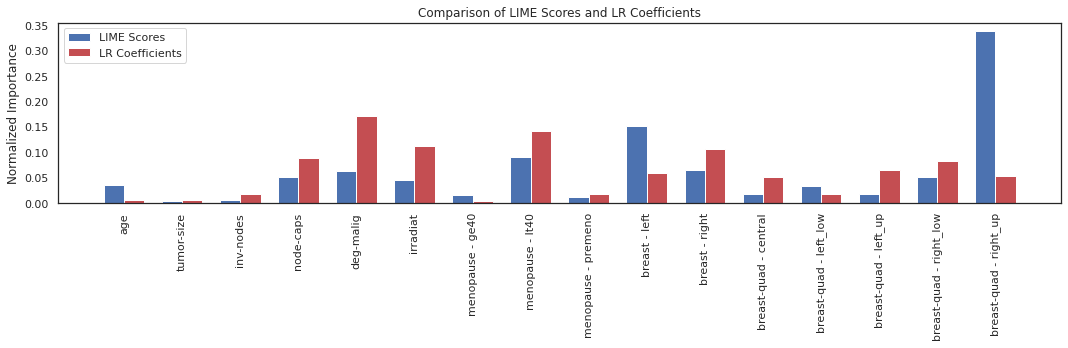

In [ ]:
# Load data
df = pd.read_csv(TRAIN_FILE_FOLDER + 'breast_cancer_preprocessed.csv')
df = bc_preprocess(df)

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Initialize LIME explainer
#explainer = LimeTabularExplainer(X, mode='classification', feature_names=cols, class_names=df['recurrence'].unique().tolist())
explainer = LimeTabularExplainer(X, mode='classification', feature_names=cols, class_names=['no-recurrence-events','recurrence-events'])

# Aggregate LIME importance scores
lime_scores = np.zeros(X.shape[1])

for i in range(X.shape[0]):
    exp = explainer.explain_instance(X[i], clf_lr.predict_proba, num_features=X.shape[1])
    for feature, score in exp.as_list():
        # Extract the base feature name from the LIME explanation
        base_feature_name = feature.split(' <= ')[0].split(' > ')[0]
        if base_feature_name in cols:
            feature_idx = cols.index(base_feature_name)
            lime_scores[feature_idx] += np.abs(score)  # We consider the absolute value for aggregation

# Normalize LIME scores and LR coefficients for comparison
lime_scores_normalized = lime_scores / np.sum(lime_scores)
lr_coef_normalized = np.abs(clf_lr.coef_[0]) / np.sum(np.abs(clf_lr.coef_[0]))  # We consider the absolute value of coefficients

# Plotting
plt.figure(figsize=(15, 5))
x = np.arange(len(cols))
width = 0.35

plt.bar(x - width/2, lime_scores_normalized, width, label='LIME Scores', color='b')
plt.bar(x + width/2, lr_coef_normalized, width, label='LR Coefficients', color='r')

plt.xticks(x, cols, rotation=90)
plt.ylabel('Normalized Importance')
plt.title('Comparison of LIME Scores and LR Coefficients')
plt.legend()

plt.tight_layout()
plt.show()


Conclusion: As you can LIME scores do not align with LR score. Hence we can conclude that LIME results does not support LR feature ranking

Exercise 2. According to LIME which classifier is more robust in newsgroups problem?



Ans: After lookinng at output of both explainer, Neither of explanaers are godd at explaining the caegory.
Relatively first explainer (for svc) seems to be more robust than the second one (for random forest) . This is because the second algorithm highlights 5 stop words like in, but , whatm, Re etc in a gorup of 7 words. These 5 words do not convey any semantic meaning. The first algorithm, highlights important words like Shaft and people names Winona, Stafford, do with very little noise. The explanation for miscelleneous and parts and people names does more sound logical for miscellenous sale category as compared to explainer for explainer 2.

In [ ]:
df.head()

age menopause  tumor-size  inv-nodes node-caps  deg-malig breast  \
0   44   premeno          18          0       yes          3  right   
1   58      ge40          18          1        no          1  right   
2   51      ge40          39          0        no          2   left   
3   49   premeno          35          1       yes          3  right   
4   41   premeno          32          5       yes          2   left   

  breast-quad irradiat            recurrence  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Build transactions
df = pd.read_csv(TRAIN_FILE_FOLDER + 'breast_cancer_preprocessed.csv')
df = bc_preprocess(df)
df.head()


Index(['node-caps', 'breast-quad'], dtype='object')
Index([], dtype='object')
#rows= 277 #columns= 10


age menopause  tumor-size  inv-nodes node-caps  deg-malig breast  \
0   44   premeno          18          0       yes          3  right   
1   58      ge40          18          1        no          1  right   
2   51      ge40          39          0        no          2   left   
3   49   premeno          35          1       yes          3  right   
4   41   premeno          32          5       yes          2   left   

  breast-quad irradiat            recurrence  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events

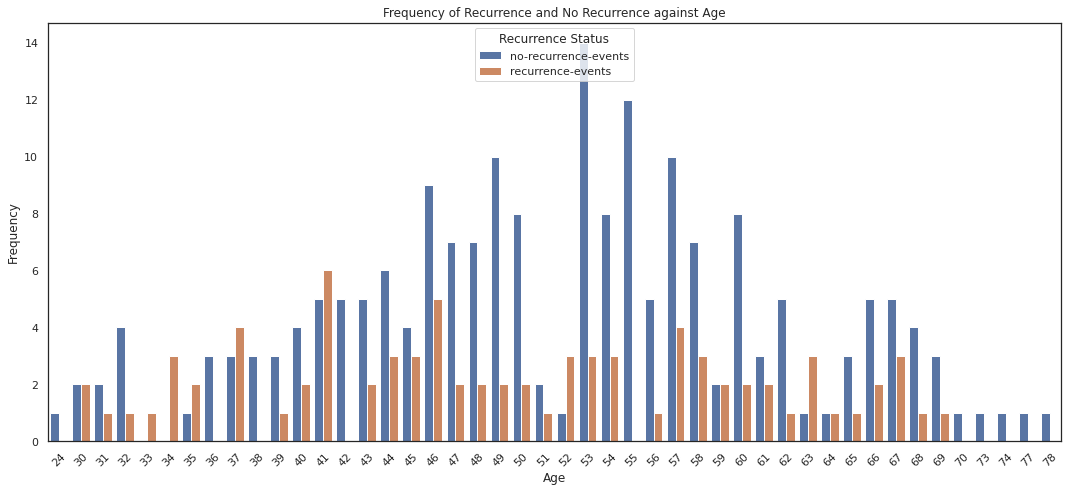

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your dataframe

# Create a grouped dataframe to count occurrences of recurrence and no recurrence for each age
grouped_df = df.groupby(['age', 'recurrence']).size().reset_index(name='count')

# Bar plot
plt.figure(figsize=(15,7))
sns.barplot(data=grouped_df, x='age', y='count', hue='recurrence')
plt.title('Frequency of Recurrence and No Recurrence against Age')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.xticks(rotation=45)
plt.legend(title='Recurrence Status')
plt.tight_layout()
plt.show()


Above graph plots frequency of recurrence and no recurrence against age. As you can see at lower age ranges the no recurrence event dominates and at higher age the gap between no recurrence and recurence keeps decreasing. It thus proves as age increase the probability of recurrence (recurrence / (recurrence = no recurrence)) increases thus establishing posistive correlation.

Exercise 3. Why is that the correlation between Recurrence and Age is reddish (as opposed to blueish)?



A Reddish correlarion indicates posistive correlation and a blueish correlation indicate negative correlation. Agen and Recurrence exshibits reddish correlation because in the dataset as age increases, recurrence pattenrns increases as well.

Exercise 4. Determine a rule with 'ts_large' and find out its highest support and confidence.


Ans: To determine a rule with 'ts_large' and find out its highest support and confidence, we'll need to use association rule mining techniques, such as the Apriori algorithm

We'll disceretize cancer dataset features, apply apriori algorithm, generate association rules and filters rules with ts_large and then sort by highest support and confidance

In [ ]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
# Build transactions
df = pd.read_csv(TRAIN_FILE_FOLDER + 'breast_cancer_preprocessed.csv')
df = bc_preprocess(df)
df.head()

Index(['node-caps', 'breast-quad'], dtype='object')
Index([], dtype='object')
#rows= 277 #columns= 10


age menopause  tumor-size  inv-nodes node-caps  deg-malig breast  \
0   44   premeno          18          0       yes          3  right   
1   58      ge40          18          1        no          1  right   
2   51      ge40          39          0        no          2   left   
3   49   premeno          35          1       yes          3  right   
4   41   premeno          32          5       yes          2   left   

  breast-quad irradiat            recurrence  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events

In [ ]:
# Convert variables to nominal
df.loc[df['age']<=40, 'dage'] = 'young'
df.loc[(df['age']>40)&(df['age']<=60), 'dage'] = 'aged'
df.loc[df['age']>60, 'dage'] = 'senior'

df.loc[df['tumor-size']<=20, 'dtumorsize'] = 'ts_small'
df.loc[(df['tumor-size']>20)&(df['tumor-size']<=40), 'dtumorsize'] = 'ts_medium'
df.loc[df['tumor-size']>40, 'dtumorsize'] = 'ts_large'

df.loc[df['inv-nodes']<5, 'dnodes'] = 'nodes_low'
df.loc[df['inv-nodes']>=5, 'dnodes'] = 'nodes_high'

df.loc[df['deg-malig']<=1, 'dmalig'] = 'malig_low'
df.loc[df['deg-malig']==2, 'dmalig'] = 'malig_med'
df.loc[df['deg-malig']>=2, 'dmalig'] = 'malig_high'

df['node-caps'].replace({'no':'nc_no','yes':'nc_yes'}, inplace=True)
df['breast'].replace({'left':'br_left','right':'br_right'}, inplace=True)
df['irradiat'].replace({'no':'ir_no','yes':'ir_yes'}, inplace=True)

df.drop(columns=['age', 'tumor-size', 'inv-nodes', 'deg-malig'], inplace=True)
df.head()

menopause node-caps    breast breast-quad irradiat            recurrence  \
0   premeno    nc_yes  br_right     left_up    ir_no     recurrence-events   
1      ge40     nc_no  br_right     central    ir_no  no-recurrence-events   
2      ge40     nc_no   br_left    left_low    ir_no     recurrence-events   
3   premeno    nc_yes  br_right    left_low   ir_yes  no-recurrence-events   
4   premeno    nc_yes   br_left    right_up    ir_no     recurrence-events   

   dage dtumorsize      dnodes      dmalig  
0  aged   ts_small   nodes_low  malig_high  
1  aged   ts_small   nodes_low   malig_low  
2  aged  ts_medium   nodes_low  malig_high  
3  aged  ts_medium   nodes_low  malig_high  
4  aged  ts_medium  nodes_high  malig_high

In [ ]:

# Convert the discretized dataset into a one-hot encoded format
df_onehot = pd.get_dummies(df)

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_onehot, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)

# Filter rules with 'mean radius_high' as an antecedent
#filtered_rules = rules[rules['antecedents'] == {'dmalig'}]

# Sort and display the filtered rules by support and confidence
#print(filtered_rules.sort_values(by=['support', 'confidence'], ascending=False))
# Display top rules
print(rules.sort_values(by=['support', 'confidence'], ascending=False).head())

            antecedents         consequents  antecedent support  \
140   (node-caps_nc_no)  (dnodes_nodes_low)            0.797834   
141  (dnodes_nodes_low)   (node-caps_nc_no)            0.826715   
412    (irradiat_ir_no)  (dnodes_nodes_low)            0.776173   
413  (dnodes_nodes_low)    (irradiat_ir_no)            0.826715   
118    (irradiat_ir_no)   (node-caps_nc_no)            0.776173   

     consequent support   support  confidence      lift  leverage  conviction  \
140            0.826715  0.754513    0.945701  1.143927  0.094932    3.191336   
141            0.797834  0.754513    0.912664  1.143927  0.094932    2.314801   
412            0.826715  0.696751    0.897674  1.085833  0.055077    1.693469   
413            0.776173  0.696751    0.842795  1.085833  0.055077    1.423787   
118            0.797834  0.675090    0.869767  1.090161  0.055833    1.552347   

     zhangs_metric  
140       0.622351  
141       0.726077  
412       0.353167  
413       0.456174  
118  

In [ ]:

# Filter rules with 'irradiat_ir_no' as an antecedent
filtered_rules = rules[rules['antecedents'] == {'ts_large'}]

# Sort and display the filtered rules by support and confidence
print(filtered_rules.sort_values(by=['support', 'confidence'], ascending=False))


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


# Analysis
ts_large has no strong association even after lowering threshold on support and confidance to lowest value.
Lets try filtering by 'irradiat_ir_no'

In [ ]:

# Filter rules with 'irradiat_ir_no' as an antecedent
filtered_rules = rules[rules['antecedents'] == {'irradiat_ir_no'}]

# Sort and display the filtered rules by support and confidence
print(filtered_rules.sort_values(by=['support', 'confidence'], ascending=False))


              antecedents                                        consequents  \
412      (irradiat_ir_no)                                 (dnodes_nodes_low)   
118      (irradiat_ir_no)                                  (node-caps_nc_no)   
3675     (irradiat_ir_no)                (node-caps_nc_no, dnodes_nodes_low)   
395      (irradiat_ir_no)                  (recurrence_no-recurrence-events)   
414      (irradiat_ir_no)                                (dmalig_malig_high)   
...                   ...                                                ...   
1630629  (irradiat_ir_no)  (breast_br_left, breast-quad_left_low, recurre...   
1631649  (irradiat_ir_no)  (breast_br_left, dage_aged, recurrence_no-recu...   
1632673  (irradiat_ir_no)  (breast_br_left, breast-quad_right_up, recurre...   
1634714  (irradiat_ir_no)  (dage_aged, recurrence_no-recurrence-events, m...   
1635737  (irradiat_ir_no)  (breast-quad_right_up, dage_aged, recurrence_n...   

         antecedent support  consequent

# Analysis
irradiat_ir_no has strong association with dnodes_nodes_low

In [ ]:
# Check the distribution of 'ts_large'
print(df['dtumorsize'].value_counts())

# Check the overall distribution of all items
print(df_onehot.sum().sort_values(ascending=False))


ts_medium    173
ts_small      78
ts_large      26
Name: dtumorsize, dtype: int64
dnodes_nodes_low                   229
node-caps_nc_no                    221
irradiat_ir_no                     215
dmalig_malig_high                  211
recurrence_no-recurrence-events    196
dage_aged                          184
dtumorsize_ts_medium               173
menopause_premeno                  149
breast_br_left                     145
breast_br_right                    132
menopause_ge40                     123
breast-quad_left_low               106
breast-quad_left_up                 94
recurrence_recurrence-events        81
dtumorsize_ts_small                 78
dmalig_malig_low                    66
irradiat_ir_yes                     62
node-caps_nc_yes                    56
dage_senior                         50
dnodes_nodes_high                   48
dage_young                          43
breast-quad_right_up                33
dtumorsize_ts_large                 26
breast-quad_right_low

Analysis:
When sorted by highest support and confidance and filtered by irradiat_ir_no , we can see that dnodes_nodes_low is top cosequence for irradiat_ir_no.
We could change the

1. [50 pts] Build a model for the MNIST dataset provided in the module. Use LIME image
explainer LimeImageExplainer to find out how digits are predicted. Plot one good example
explanation figure for every digit 0 to 9. Note that you can use any model as you see fit
(algorithms from sklearn are the easiest). CNN (PyTorch) models are recommended to achieve
almost perfect learning.
Do you need to setup a training and testing set? Note that one could use regularization, robust
CNN, and dropout to achieve non-overfitting on reclassification.
Comment on results. Are there any specific patterns discriminating certain digits?




The MNIST dataset is a collection of handwritten digits, and it's commonly used for training various image processing systems. It contains 60,000 training images and 10,000 testing images.

We'll first train a CNN model to recognize digits. We do need to train model to see how well Explaner can explaoin model's output.
We'll pass then the image and predicted labels to explaner to compare predicted image and mask from the explaner and superpixels.

# Get the Mnist data and split the data into train and test dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST training and test datasets
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders for training and testing sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)


#  Here's a simple CNN architecture using PyTorch

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(10816, 128)  # Adjusted input dimension
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)



# Lets Train SimpleCNN model on MNIST Dataset

In [ ]:
import torch.optim as optim

# Define the model
model = SimpleCNN()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (for simplicity, we'll do just a few epochs here)
num_epochs = 5
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("Finished Training")


Finished Training


In [ ]:
import torch.nn.functional as F

def predict(data):
    # Set the model to evaluation mode
    model.eval()

    # Ensure the data has the correct shape
    if len(data.shape) == 4 and data.shape[1] == 3:  # If the data has shape [batch_size, channels, height, width] and 3 channels
        data = np.mean(data, axis=1, keepdims=True)  # Convert to grayscale by averaging the channels
    elif len(data.shape) == 4 and data.shape[3] == 3:  # If the data has shape [batch_size, height, width, channels]
        data = np.mean(data, axis=3, keepdims=True)  # Convert to grayscale by averaging the channels
        data = np.transpose(data, (0, 3, 1, 2))  # Change to [batch_size, channels, height, width]

    # Convert the data to a PyTorch tensor
    data = torch.tensor(data, dtype=torch.float32)

    # Get the model's raw output
    output = model(data)

    # Convert the raw output to probabilities using softmax
    probs = F.softmax(output, dim=1)

    return probs.detach().numpy()






# Write a code to test the predicted label and actual label for random test image

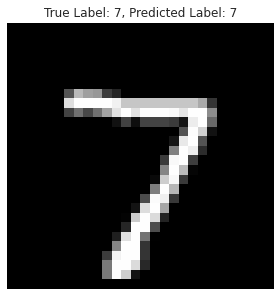

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a random image from the test_set
#index = random.randint(0, len(test_set) - 1)
index = 0
image, true_label = test_set[index]

# Convert the image to a batch of size 1 and predict its label using the model
image_batch = image.unsqueeze(0)  # Add a batch dimension
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradient computation
    output = model(image_batch)
    predicted_label = torch.argmax(output).item()

# Visualize the image along with the true and predicted labels
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()


# Select image from the test set plt the inage and label before passing to explainer

7


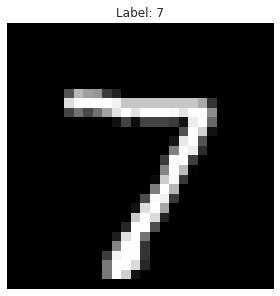

In [ ]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)



# Select an image from the test_set (e.g., the first image)
image, label = test_set[0]

print(label)

# Convert the PyTorch tensor to a numpy array
image_np = image.numpy()

# Since the image tensor shape is [channels, height, width], we need to transpose it to [height, width, channels] for visualization
image_np = np.transpose(image_np, (1, 2, 0))

# Plot the image before passing it the explainer
plt.imshow(image_np.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()




# Lets use Explainer to justify

  0%|          | 0/1000 [00:00<?, ?it/s]

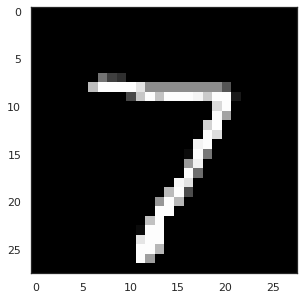

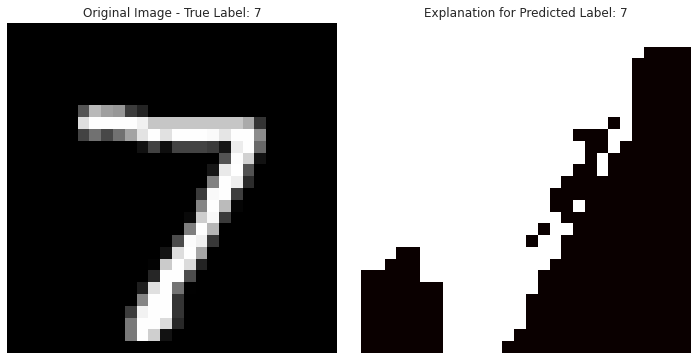

In [ ]:
# Choose an image from the test set
image = test_set[0][0].numpy().reshape(28, 28)

predicted_label = 7
true_label = 7
# Get the explanation for the chosen image
explanation = explainer.explain_instance(image, predict, top_labels=10, hide_color=0, num_samples=1000, segmentation_fn=segmenter)

# Plot the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
plt.imshow(temp, interpolation='none')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
ax1.imshow(image.squeeze(), cmap='gray')
ax1.set_title(f"Original Image - True Label: {true_label}")
ax1.axis('off')

# Plot the explanation mask
ax2.imshow(mask, cmap='hot')
ax2.set_title(f"Explanation for Predicted Label: {predicted_label}")
ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Check the available keys in the local_exp dictionary
available_keys = explanation.local_exp.keys()

# Convert the predicted_label to the appropriate type if needed
if isinstance(list(available_keys)[0], str) and isinstance(predicted_label, int):
    predicted_label = str(predicted_label)
elif isinstance(list(available_keys)[0], int) and isinstance(predicted_label, str):
    predicted_label = int(predicted_label)

# Ensure the predicted_label is in the available keys
if predicted_label in available_keys:
    features = explanation.local_exp[predicted_label]
    sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

    # Print the textual explanation
    print(f"Explanation for Predicted Label: {predicted_label}\n")
    print("Feature (Superpixel) \t Weight")
    print("--------------------- \t ------")
    for feature, weight in sorted_features:
        print(f"{feature} \t\t {weight:.4f}")
else:
    print(f"No explanation available for label {predicted_label}. Available labels are: {available_keys}")


Explanation for Predicted Label: 7

Feature (Superpixel) 	 Weight
--------------------- 	 ------
3 		 0.2716
0 		 0.1630
1 		 0.1031
6 		 0.0876
4 		 0.0763
5 		 -0.0136
2 		 -0.0274


# Superpixel:
A superpixel is a group of pixels that are adjacent and share similar attributes, such as color or texture. The idea behind superpixels is to replace a grid of pixels with a more meaningful and compact representation that respects the boundaries of objects within an image.
** The code below prints a list (superpixels) and their corresponding weights. Features with higher weights had a more significant influence on the model's prediction. By analyzing these weights, you can understand which parts of the image were most important for the model's decision.

In [ ]:

# Get the list of features and their weights from the explanation
features = explanation.local_exp[predicted_label]

# Sort the features based on their weights in descending order
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# Print the textual explanation
print(f"Explanation for Predicted Label: {predicted_label}\n")
print("Feature (Superpixel) \t Weight")
print("--------------------- \t ------")
for feature, weight in sorted_features:
    print(f"{feature} \t\t {weight:.4f}")


Explanation for Predicted Label: 7

Feature (Superpixel) 	 Weight
--------------------- 	 ------
3 		 0.2716
0 		 0.1630
1 		 0.1031
6 		 0.0876
4 		 0.0763
5 		 -0.0136
2 		 -0.0274


## Explanation
* The output from LIME, which consists of the original image and the mask, provides a visual explanation of the model's decision.

* Original Image: This is the image for which we want an explanation. It's the input to the model.

* Mask (Explanation): The mask highlights the regions in the image that influenced the model's decision the most. The brighter areas in the mask are the most influential regions, while the darker areas had less or no influence on the prediction.

* Here is explanation the model's decision using the mask:

Bright Regions: If we look at brighter regions in the mask. These are the areas that the model found most significant when making its prediction. For instance, in the case of the MNIST dataset, if the model predicted the digit "7", the mask might highlight the i horzontal near top and diagonal line from top right to botton left which are distinctive features of the digit "7".

Dark Regions: The darker regions in the mask are areas that the model did not consider important for its prediction. These areas did not play a significant role in the model's decision.

As you can see in the image, bright region are highlighting approximately digit 7

Comparison with Original Image: By comparing the original image with the mask, we can see which specific features or patterns in the image led the model to its prediction. For instance, if certain strokes or curves in the digit are highlighted in the mask, it indicates that those specific features were crucial for the model's decision.

* Superpixel:
** A superpixel is a group of pixels that are adjacent and share similar attributes, such as color or texture. The idea behind superpixels is to replace a grid of pixels with a more meaningful and compact representation that respects the boundaries of objects within an image.
**  The code above prints a list (superpixels) and their corresponding weights. Features with higher weights had a more significant influence on the model's prediction. By analyzing these weights, you can understand which parts of the image were most important for the model's decision.



Overall the mask from LIME provides a visual representation of the model's decision-making process. By analyzing the highlighted regions in the mask and comparing them with the original image, we  gain insights into the model's behavior, understand its strengths and weaknesses, and potentially improve its performance.

2. [50 pts] Rework on the MovieLens dataset to determine a set of 19 tags that explains one
of the 19 Genres while having an inert relation with the rest of the genres. Clearly, we
should not use the genre term itself. And those 19 terms must encompass the genres. An
example would be the term cowboy for Western movies.
The set of the tags can come from the movielens_genome_tags.csv. However, you are free
to use GloVe or any other vocabulary source that explains the genre. If one uses a
particular approach to determine terms (with max-score to genre and min-scores to the
rest) then all 19 terms must be discovered in that manner.
(Hint: A sort function with 19 components where each component could be the distance to
the genre might work, such as, cost = -g1 + g2 + g3 + ... + g19) where g is the distance and
cost is minimized for genre 1).
Note that you can approach this problem in any way you like. Above steps are just
guidance.

## Approach  : Using GloVe embeddings can provide a more semantic representation of the tag and genre. I'll use cosine similarity between tag and genre to find similarity distance. Then I'll Sort the tags by distance to find top tag
1. Load the movies, genres and genome tags dataset
2. Extract Unique Genres (set of 19 tags) from moveis dataset
3. For each tag in movielens_genome_tags.csv, compute its embedding using the GloVe model.
4. For each genre, compute its embedding using the GloVe model
4. For each genre, compute the cosine similarity between its embedding and the embeddings of all tags.
5. Select the tag with the highest cosine similarity as the best tag for that genre.

In [ ]:
import pandas as pd
import numpy as np
import gensim.downloader

# Load datasets
df_movies = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens/' + 'movielens_movie.csv')
df_genome_tags = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens/' + 'movielens_genome_tags.csv')
df_genome_scores = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens/' 'movielens_genome_scores.csv')


In [ ]:

# Extract unique genres
all_genres = set()
for genre_str in df_movies['genres']:
    genres = genre_str.split('|')
    all_genres.update(genres)
all_genres = list(all_genres)
all_genres.remove('(no genres listed)')  # Remove the 'no genres listed' entry


In [ ]:

# Load GloVe embeddings
Glove = gensim.downloader.load('glove-wiki-gigaword-50')

In [ ]:
Glove['mystery']

array([ 1.2302  ,  1.008   , -0.66763 ,  0.16754 ,  0.71197 ,  0.7279  ,
       -0.38084 , -0.20591 ,  0.32334 ,  0.25653 , -0.61247 ,  0.65835 ,
       -0.60964 ,  0.71088 ,  1.4034  , -0.27647 , -0.16267 ,  0.36058 ,
       -0.85805 ,  0.47634 ,  0.27719 ,  0.50255 ,  0.11735 ,  0.75564 ,
        0.70533 , -1.2505  , -1.4989  ,  0.22046 ,  0.53069 ,  0.099463,
        1.216   , -0.68668 ,  0.10602 , -0.81001 , -0.057511,  0.47171 ,
       -0.66237 , -0.54177 ,  0.13896 , -0.70095 , -0.019101,  0.29742 ,
        0.012637,  0.15419 ,  0.18091 ,  0.95648 ,  0.87226 ,  0.069793,
       -0.039322, -0.33395 ], dtype=float32)

In [ ]:


# Compute tag embeddings
tag_embeddings = {}
for _, row in df_genome_tags.iterrows():
    tag = row['tag'].lower()
    if tag in Glove:
        tag_embeddings[tag] = Glove[tag]

# Compute genre embeddings
genre_embeddings = {}
for genre in all_genres:
    words = genre.split()
    print(words)
    embeddings = [Glove[word.lower()] for word in words if word.lower() in Glove]
    if embeddings:
        genre_embeddings[genre] = np.mean(embeddings, axis=0)

# Ensure genre_embeddings is not empty
if not genre_embeddings:
    raise ValueError("No genre embeddings could be computed. Please ensure the genres match the GloVe vocabulary.")



['Musical']
['War']
['Adventure']
['Crime']
['Sci-Fi']
['Action']
['Documentary']
['IMAX']
['Drama']
['Western']
['Thriller']
['Mystery']
['Horror']
['Children']
['Romance']
['Fantasy']
['Animation']
['Comedy']
['Film-Noir']


In [ ]:
len(genre_embeddings)

18

In [ ]:
# Determine best tags for each genre using cosine similarity
best_tags_for_genres = {}
for genre, genre_emb in genre_embeddings.items():
    max_similarity = -np.inf
    best_tag = None
    for tag, tag_emb in tag_embeddings.items():
        similarity = np.dot(genre_emb, tag_emb) / (np.linalg.norm(genre_emb) * np.linalg.norm(tag_emb))
        if similarity > max_similarity and tag.lower() != genre.lower():
            max_similarity = similarity
            best_tag = tag
    best_tags_for_genres[genre] = best_tag

print(best_tags_for_genres)


{'Musical': 'music', 'War': 'fighting', 'Adventure': 'fantasy', 'Crime': 'murder', 'Sci-Fi': 'spoof', 'Action': 'terrorism', 'Documentary': 'drama', 'IMAX': 'animation', 'Drama': 'comedy', 'Western': 'africa', 'Thriller': 'horror', 'Mystery': 'story', 'Horror': 'drama', 'Children': 'kids', 'Romance': 'romantic', 'Fantasy': 'adventure', 'Animation': 'animated', 'Comedy': 'drama'}


#Analysis
As you can see relationship between tag and genre is sobvious in few cases
 'Children': 'kids', 'Thriller': 'horror', 'War': 'fighting'
 It is less obvious in few other cases
 'Drama': 'comedy', 'Western': 'africa'
